# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors
import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [2]:
dt = 1/24 # time step in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

In [3]:
h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [4]:
h_hat, w = sp.filter_response(h, dt)

No handles with labels found to put in legend.


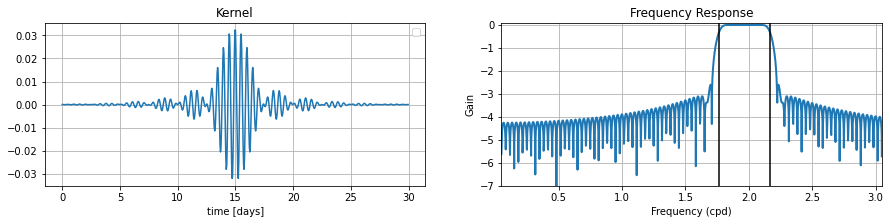

In [5]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband, color='k')
ax.axvline(omega+dband, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

---

## Hilbert transform

### apply band-passed filter and hilbert transform

In [24]:
# generate synthetic data
T,T_low = 20,10
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

def tseries(kind, params={}, **kwargs):
    _kwargs = dict(time=(1000, 1/24), 
                   seed=0,
                  )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind=="high_M2":
        p = dict(U=[0.01, .1, 1.], T=T, sigma=omega_M2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (rename_attrs(da, T_high="T")
              .rename(U='U_high')
             )
    elif kind=="high_S2":
        p = dict(U=[0.01, .1, 1.], T=T, sigma=omega_S2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (rename_attrs(da, T_high="T")
              .rename(U='U_high')
             )
    else:
        p = dict(T=T_low)
        p.update(**params)
        da = (u_low
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = rename_attrs(da, T_low="T", U_low="U")
    return da
    

# actually generate time series
da_high_M2 = tseries("high_M2")
da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2")
da_high_S2 = da_high_S2.rename('high_S2')
da_low = tseries("low")

In [23]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma'],'T_high':da_high_M2.attrs['T_high']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma'],'T_high':da_high_S2.attrs['T_high']}

ds_100 = xr.merge([da_high_M2,da_high_S2, da_low], combine_attrs="no_conflicts")

ds_100

<xarray.Dataset>
Dimensions:  (U_high: 3, time: 24000)
Coordinates:
  * U_high   (U_high) float64 0.01 0.1 1.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    high_M2  (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    high_S2  (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    low      (time) float64 dask.array<chunksize=(24000,), meta=np.ndarray>
Attributes:
    sigma_M2:  12.140833182614747
    T_high:    100
    sigma_S2:  12.566370614359172
    T_low:     10
    U_low:     1.0

In [25]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma'],'T_high':da_high_M2.attrs['T_high']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma'],'T_high':da_high_S2.attrs['T_high']}

ds_20 = xr.merge([da_high_M2,da_high_S2, da_low], combine_attrs="no_conflicts")

ds_20

<xarray.Dataset>
Dimensions:  (U_high: 3, time: 24000)
Coordinates:
  * U_high   (U_high) float64 0.01 0.1 1.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    high_M2  (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    high_S2  (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    low      (time) float64 dask.array<chunksize=(24000,), meta=np.ndarray>
Attributes:
    sigma_M2:  12.140833182614747
    T_high:    20
    sigma_S2:  12.566370614359172
    T_low:     10
    U_low:     1.0

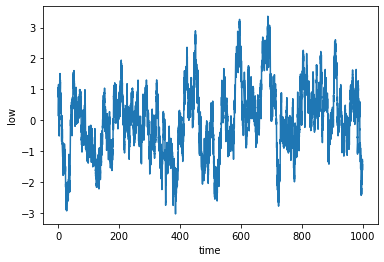

<Figure size 432x288 with 0 Axes>

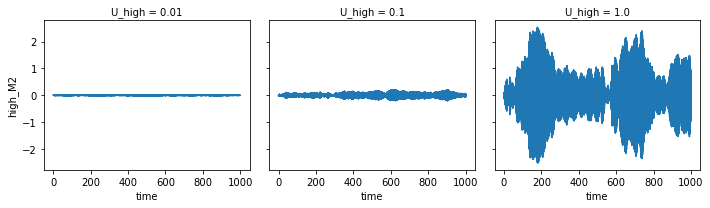

In [27]:
ds_100.low.plot()
plt.figure()
ds_100.high_M2.plot(col='U_high')

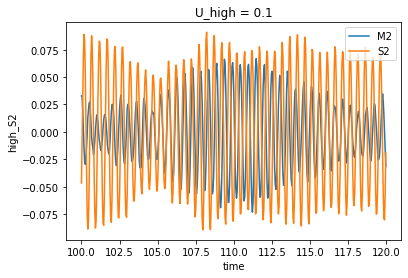

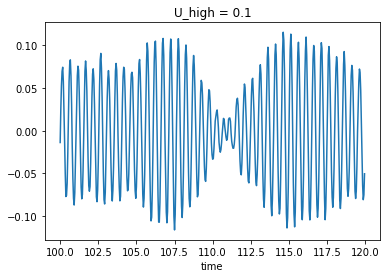

In [28]:
ds_100.high_M2.sel(U_high=0.1).where( (ds_100.time>=100) & (ds_100.time<120) ).plot(label='M2')
ds_100.high_S2.sel(U_high=0.1).where( (ds_100.time>=100) & (ds_100.time<120) ).plot(label='S2')
plt.legend()
plt.figure()
(ds_100.high_S2+ds_100.high_M2).sel(U_high=0.1).where( (ds_100.time>=100) & (ds_100.time<120) ).plot(label='S2')

In [29]:
ds_100['high'] = ds_100.high_M2+ds_100.high_S2
ds_100['total'] = ds_100.high_M2+ds_100.high_S2+ds_100.low

ds_20['high'] = ds_20.high_M2+ds_20.high_S2
ds_20['total'] = ds_20.high_M2+ds_20.high_S2+ds_20.low

In [30]:
ds_100

<xarray.Dataset>
Dimensions:  (U_high: 3, time: 24000)
Coordinates:
  * U_high   (U_high) float64 0.01 0.1 1.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    high_M2  (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    high_S2  (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    low      (time) float64 dask.array<chunksize=(24000,), meta=np.ndarray>
    high     (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
    total    (U_high, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
Attributes:
    sigma_M2:  12.140833182614747
    T_high:    100
    sigma_S2:  12.566370614359172
    T_low:     10
    U_low:     1.0

In [31]:
_ds_100,h = {},{}
for om,kind in zip([omega_M2,omega_S2,omega,omega],['high_M2','high_S2','high','total']):
    _ds_100[kind] = sigp.bpass_demodulate(ds_100[[kind]], om, dband, Tw)[0]
    h[kind] = sigp.bpass_demodulate(ds_100[[kind]], om, dband, Tw)[1]

In [32]:
_ds_20,h = {},{}
for om,kind in zip([omega_M2,omega_S2,omega,omega],['high_M2','high_S2','high','total']):
    _ds_20[kind] = sigp.bpass_demodulate(ds_20[[kind]], om, dband, Tw)[0]
    h[kind] = sigp.bpass_demodulate(ds_20[[kind]], om, dband, Tw)[1]

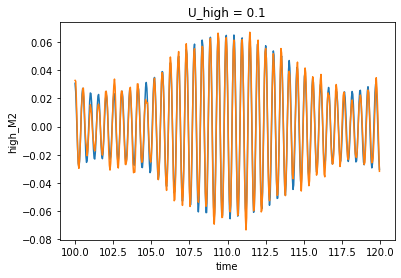

In [33]:
_ds_100['high_M2'].high_M2_bpassed.real.sel(U_high=0.1).where( (_ds_100['high_M2'].time>=100) & (_ds_100['high_M2'].time<120) ).plot(label='M2')
_ds_100['high_M2'].high_M2.sel(U_high=0.1).where( (_ds_100['high_M2'].time>=100) & (_ds_100['high_M2'].time<120) ).plot(label='M2')

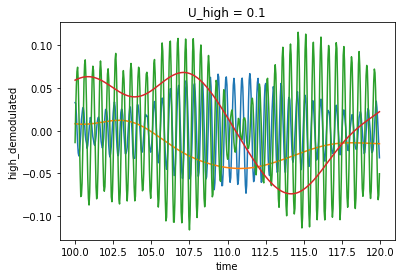

In [34]:
_ds_100['high_M2'].high_M2.sel(U_high=0.1).where( (_ds_100['high_M2'].time>=100) & (_ds_100['high_M2'].time<120) ).plot(label='M2')
_ds_100['high_M2'].high_M2_demodulated.real.sel(U_high=0.1).where( (_ds_100['high_M2'].time>=100) & (_ds_100['high_M2'].time<120) ).plot(label='M2')
_ds_100['high'].high.real.sel(U_high=0.1).where( (_ds_100['high_M2'].time>=100) & (_ds_100['high_M2'].time<120) ).plot(label='M2')
_ds_100['high'].high_demodulated.real.sel(U_high=0.1).where( (_ds_100['high_M2'].time>=100) & (_ds_100['high_M2'].time<120) ).plot(label='M2')

In [21]:
def autocorrelations(ds, V,combine=False):
#    V = ["high", "low"]
    if combine:
        ds["sum"] = ds["high"]  + ds["low"]
        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
        V = V + ["sum"]
    R = []
    for v in V:
        R.append((sigp
                  .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
    return xr.merge(R)

In [35]:
R_100 = {}
for kind in ['high_M2','high_S2','high','total']:
    R_100[kind] = autocorrelations(_ds_100[kind],[kind])

R_20 = {}
for kind in ['high_M2','high_S2','high','total']:
    R_20[kind] = autocorrelations(_ds_20[kind],[kind])
#R

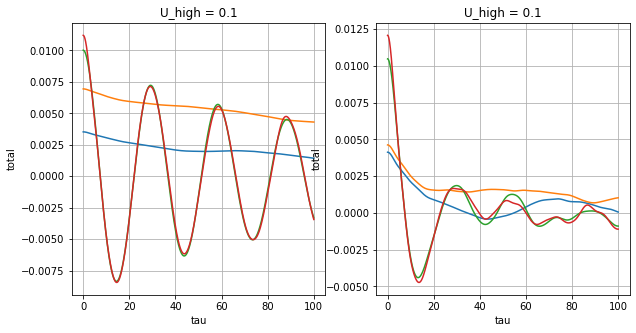

In [42]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
R_100['high_M2'].sel(U_high=0.1).high_M2.sel(tau=slice(0,100)).plot(ax=ax[0])
R_100['high_S2'].sel(U_high=0.1).high_S2.sel(tau=slice(0,100)).plot(ax=ax[0])
R_100['high'].sel(U_high=0.1).high.sel(tau=slice(0,100)).plot(ax=ax[0])
R_100['total'].sel(U_high=0.1).total.sel(tau=slice(0,100)).plot(ax=ax[0])
ax[0].grid()
R_20['high_M2'].sel(U_high=0.1).high_M2.sel(tau=slice(0,100)).plot(ax=ax[1])
R_20['high_S2'].sel(U_high=0.1).high_S2.sel(tau=slice(0,100)).plot(ax=ax[1])
R_20['high'].sel(U_high=0.1).high.sel(tau=slice(0,100)).plot(ax=ax[1])
R_20['total'].sel(U_high=0.1).total.sel(tau=slice(0,100)).plot(ax=ax[1])
ax[1].grid()

### Testing parameters

In [85]:
# generate synthetic data
T,T_low = [14,29,80],10
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

def tseries(kind, params={}, **kwargs):
    _kwargs = dict(time=(1000, 1/24), 
                   seed=0,
                  )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind=="high_M2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_M2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    elif kind=="high_S2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_S2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    else:
        p = dict(T=T_low)
        p.update(**params)
        da = (u_low
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = rename_attrs(da, U_low="U") #T_low="T"
    return da

In [86]:
# actually generate time series
T,T_low = [5,10,15,29,80],[5,10,20]
da_high_M2 = tseries("high_M2")
da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2")
da_high_S2 = da_high_S2.rename('high_S2')
da_low = tseries("low")

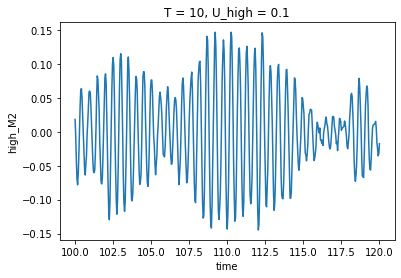

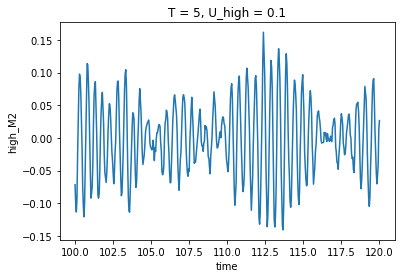

In [87]:
da_high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot()
plt.figure()
da_high_M2.isel(T=0).sel(U_high=0.1).sel(time=slice(100,120)).plot()

In [88]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})], combine_attrs="no_conflicts")
#ds = ds.assign_coords({'T':T})
ds

<xarray.Dataset>
Dimensions:  (T: 5, U_high: 4, time: 24000, T_low: 3)
Coordinates:
  * T        (T) int64 5 10 15 29 80
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * T_low    (T_low) int64 5 10 20
Data variables:
    high_M2  (T, U_high, time) float64 dask.array<chunksize=(5, 4, 24000), meta=np.ndarray>
    high_S2  (T, U_high, time) float64 dask.array<chunksize=(5, 4, 24000), meta=np.ndarray>
    low      (T_low, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
Attributes:
    sigma_M2:  12.140833182614747
    sigma_S2:  12.566370614359172
    U_low:     1.0

In [89]:
ds['high'] = ds.high_M2+ds.high_S2
ds['total'] = ds.high_M2+ds.high_S2+ds.low

In [90]:
Tw = [15,30,60]
_ds,h = {},{}
for om,kind in zip([omega_M2,omega_S2,omega,omega],['high_M2','high_S2','high','total']):
    _ds[kind] = xr.concat([sigp.bpass_demodulate(ds[[kind]], om, dband, tw)[0] for tw in Tw],dim='Tw').assign_coords({'Tw':Tw})
    h[kind] = [sigp.bpass_demodulate(ds[[kind]], om, dband, tw)[1] for tw in Tw]


In [91]:
R = {}
for kind in ['high_M2','high_S2','high','total']:
    R[kind] = autocorrelations(_ds[kind],[kind])

In [92]:
ds_R = xr.merge([R[kind] for kind in ['high_M2','high_S2','high','total']])

In [93]:
ds_R

<xarray.Dataset>
Dimensions:  (T: 5, U_high: 4, Tw: 3, tau: 12000, T_low: 3)
Coordinates:
  * T        (T) int64 5 10 15 29 80
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * Tw       (Tw) int64 15 30 60
  * tau      (tau) float64 0.0 0.04167 0.08333 0.125 ... 499.8 499.9 499.9 500.0
  * T_low    (T_low) int64 5 10 20
Data variables:
    high_M2  (Tw, T, U_high, tau) float64 dask.array<chunksize=(1, 5, 4, 12000), meta=np.ndarray>
    high_S2  (Tw, T, U_high, tau) float64 dask.array<chunksize=(1, 5, 4, 12000), meta=np.ndarray>
    high     (Tw, T, U_high, tau) float64 dask.array<chunksize=(1, 5, 4, 12000), meta=np.ndarray>
    total    (Tw, T, U_high, T_low, tau) float64 dask.array<chunksize=(1, 5, 4, 3, 12000), meta=np.ndarray>

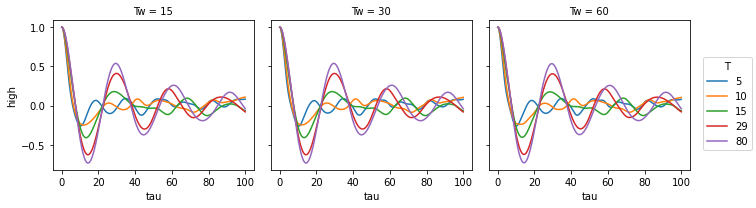

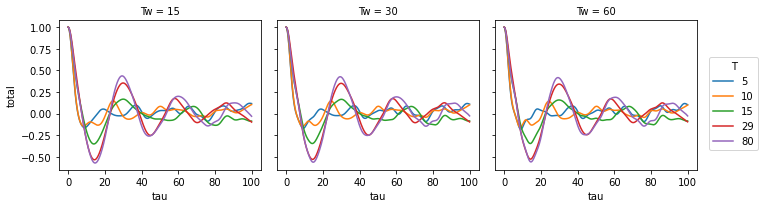

In [94]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(U_high=0.1).sel(tau=slice(0,100)).plot(hue='T',col='Tw')

(ds_R['total']/ds_R['total'].isel(tau=0)).sel(U_high=0.1,T_low=5).sel(tau=slice(0,100)).plot(hue='T',col='Tw')

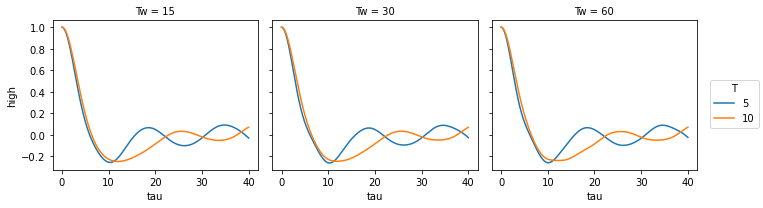

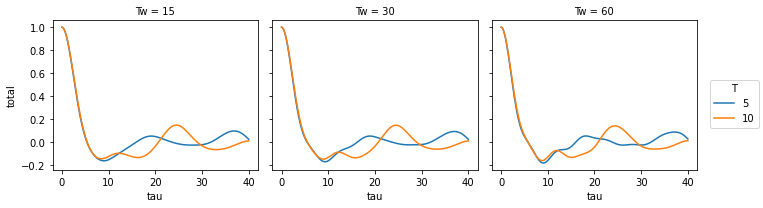

In [95]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(U_high=0.1).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

(ds_R['total']/ds_R['total'].isel(tau=0)).sel(U_high=0.1,T_low=5).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

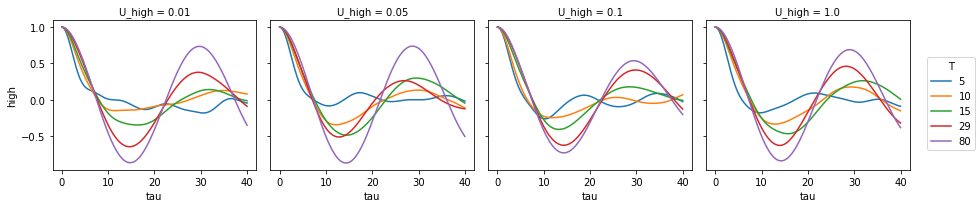

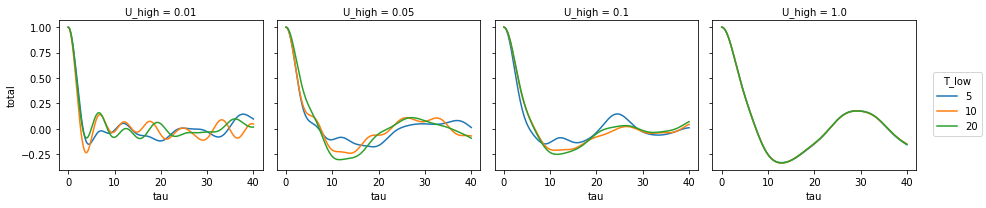

In [96]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(Tw=30).sel(tau=slice(0,40)).plot(hue='T',col='U_high')
(ds_R['total']/ds_R['total'].isel(tau=0)).sel(T=10,Tw=30).sel(tau=slice(0,40)).plot(hue='T_low',col='U_high')

### inspect with spectra: high, high_bpassed, residual

Original variance:
[5.05063900e-05 4.71183624e-03 4.65064784e-01]
From spectra:
[4.83069463e-05 4.64973743e-03 5.31643296e-01]
Ratio (spectra/original):
[0.95645217 0.98682068 1.14315965]


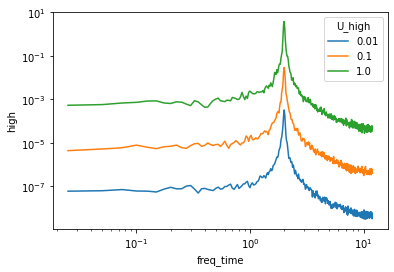

In [11]:
v="high"
ps = sigp.xrft_spectrum(ds[v])
ps.where(ps.freq_time>0).plot.line(x="freq_time", xscale='log', yscale='log')

# check Parseval:
print("Original variance:")
var_original = ds[v].var("time").values
print(var_original )
print("From spectra:")
var_spectra = np.trapz(ps.values, ps.freq_time.values)
print(var_spectra)
print("Ratio (spectra/original):")
print(var_spectra/var_original)

In [12]:
spectra = xr.merge([sigp.xrft_spectrum(np.real(ds[v])) for v in ds]
                   +[sigp.xrft_spectrum((ds[v]-np.real(ds[v+"_bpassed"])).rename(v+"_diff")) 
                     for v in ["high", "low"]
                    ],
                  )

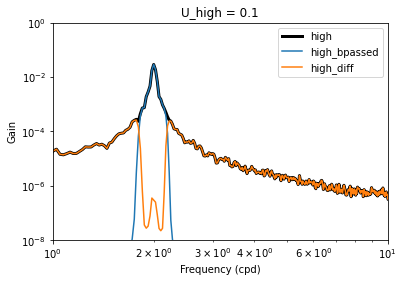

In [13]:
v = "high"

_ds = spectra.sel(U_high=0.1).where(spectra.freq_time>0)

fig, ax = plt.subplots(1,1) # figsize=(15,3)

k = dict(x="freq_time", xscale='log', yscale='log', ax=ax)
_ds[v].plot.line(lw=3, color="k", label=v, **k)
_ds[v+"_bpassed"].plot.line(label=v+"_bpassed", **k)
_ds[v+"_diff"].plot.line(label=v+"_diff", **k)

ax.axvline(sigma-hbandwidth, color='k', ls='--')
ax.axvline(sigma+hbandwidth, color='k', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e-8, 1e0)
ax.legend()

### focus on the enveloppe 

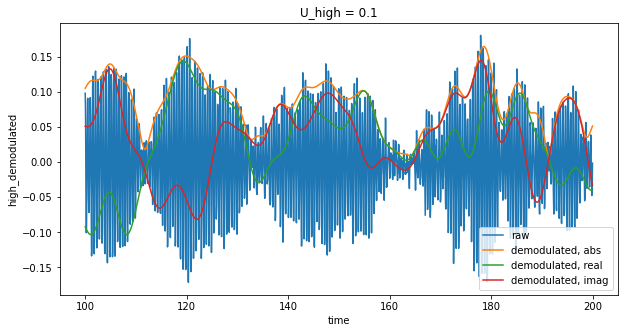

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds = ds.sel(U_high=.1).where( (ds.time>=100) & (ds.time<200) )
_ds["high"].plot.line(x='time', label="raw")
np.abs(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, abs")
np.real(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, real")
np.imag(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, imag")
plt.legend()

In [26]:
# check phase of synthetic signal
#np.abs(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, real")
#xr.apply_ufunc(np.angle, _ds["high_demodulated"], dask="parallelized").plot.line(x='time', label="demodulated, real")

### sentivity to the filter bandwidth

An halfbandwidth of $2/T_{high}$, i.e. a bandwidth of $1/T_{high}$ is sufficient to capture modulations vizually:

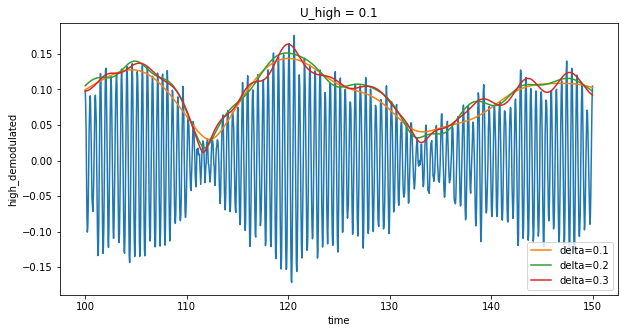

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

_ds = ds.sel(U_high=.1).where( (ds.time>=100) & (ds.time<150) )
_ds["high"].plot.line(x='time')

for hbandwidth in [1/ds.T_high, 2/ds.T_high, 3/ds.T_high]:
    ds, h, h_hat, w = sigp.bpass_demodulate(ds[["high", "low"]], sigma/rad, hbandwidth, Tw)
    _ds = ds.sel(U_high=.1).where( (ds.time>=100) & (ds.time<150) )
    np.abs(_ds["high_demodulated"]).plot.line(x='time', label="delta={}".format(hbandwidth))
plt.legend()

### autocorrelations of the enveloppe

Don't forget there will be a factor 2 between the autocorrelation of the demodulated time series and that of the full signal

In [29]:
hbandwidth = 1/ds.T_high
ds, h, h_hat, w = sigp.bpass_demodulate(ds[["high", "low"]], sigma/rad, hbandwidth, Tw)

In [30]:
def autocorrelations(ds, V,combine=False):
#    V = ["high", "low"]
    if combine:
        ds["sum"] = ds["high"]  + ds["low"]
        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
        V = V + ["sum"]
    R = []
    for v in V:
        R.append((sigp
                  .correlate(ds[v+"_demodulated"], ds[v+"_demodulated"])
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
    return xr.merge(R)

R = autocorrelations(ds)
#R

(0.0, 200.0)

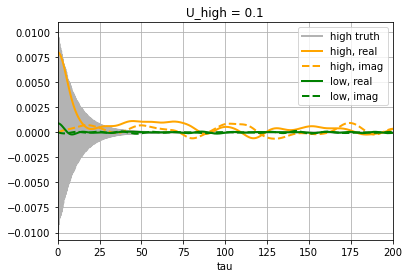

In [31]:
_ds = R.sel(U_high=0.1)

_ds['high_true'] = u_high.evaluate_autocorrelation(U=_ds.U_high, sigma=sigma, T=ds.T_high, tau=_ds.tau)

fig, ax = plt.subplots(1,1)
(2*_ds['high_true']).plot.line(x='tau', ax=ax, color='0.7', lw=2, label='high truth')
np.real(_ds['high']).plot.line(x='tau', ax=ax, color='orange', lw=2, label='high, real')
np.imag(_ds['high']).plot.line(x='tau', ax=ax, color='orange', lw=2, ls='--', label='high, imag')
np.real(_ds['low']).plot.line(x='tau', ax=ax, color='green', lw=2, label='low, real')
np.imag(_ds['low']).plot.line(x='tau', ax=ax, color='green', lw=2, ls='--', label='low, imag')
ax.grid()
ax.legend()
ax.set_ylabel(None)
#ax.set_xlim(0,10)
ax.set_xlim(0,200)

### sensibility to filter bandwidth

(0.0, 40.0)

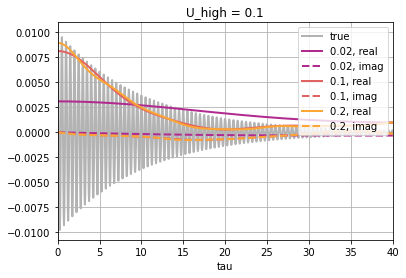

In [22]:
fig, ax = plt.subplots(1,1)

hbandwidths = [0.2/ds.T_high, 1/ds.T_high, 2/ds.T_high]
colors = get_cmap_colors(len(hbandwidths)+2, cmap='plasma')

_ds['high_true'] = u_high.evaluate_autocorrelation(U=_ds.U_high, sigma=sigma, T=ds.T_high, tau=_ds.tau)
(2*_ds['high_true']).plot.line(x='tau', ax=ax, color='0.7', lw=2, label='true')

for hbandwidth, c in zip(hbandwidths, colors[2:]):
    
    ds, h, h_hat, w = sigp.bpass_demodulate(ds[["high", "low"]], sigma/rad, hbandwidth, T_window)
    R = autocorrelations(ds)

    _ds = R.sel(U_high=0.1)
    
    np.real(_ds['high']).plot.line(x='tau', ax=ax, color=c, lw=2, label='{}, real'.format(hbandwidth))
    np.imag(_ds['high']).plot.line(x='tau', ax=ax, color=c, lw=2, ls='--', label='{}, imag'.format(hbandwidth))
    #_ds['low'].plot.line(x='tau', ax=ax, color='green', lw=2, label='low estimate')

    
ax.grid()
ax.legend(loc="upper right")
ax.set_ylabel(None)
ax.set_xlim(0,40)

### autocorrelation of combined timeseries: low + high

In [19]:
hbandwidth = 2/ds.T_high
ds, h, h_hat, w = sigp.bpass_demodulate(ds[["high", "low"]], sigma/rad, hbandwidth, T_window)

R = autocorrelations(ds, combine=True)

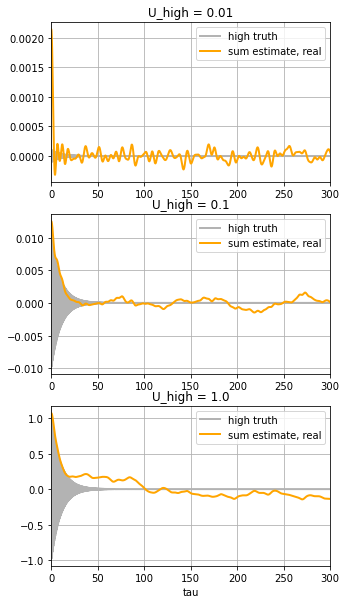

In [20]:
_u_high = R.U_high.values
fig, axes = plt.subplots(_u_high.size,1, figsize=(5,10))

for _u, ax in zip(_u_high, axes):

    _ds = R.sel(U_high=_u)
    
    _ds['high_true'] = u_high.evaluate_autocorrelation(U=_u, sigma=sigma, T=ds.T_high, tau=_ds.tau)

    (2*_ds['high_true']).plot.line(x='tau', ax=ax, color='0.7', lw=2, label='high truth')
    np.real(_ds['sum']).plot.line(x='tau', ax=ax, color='orange', lw=2, label='sum estimate, real')
    #_ds['low'].plot.line(x='tau', ax=ax, color='green', lw=2, label='low estimate')
    ax.grid()
    ax.legend()
    ax.set_ylabel(None)
    ax.set_xlim(0,300)
    if _u!=_u_high[-1]:
        ax.set_xlabel("")

### correlated real, imag demodulated signal :

- spring-neap beating

**!!! uncomplete need to ajust filtering bandwidth with respect to spring/neap frequency separation !!!**


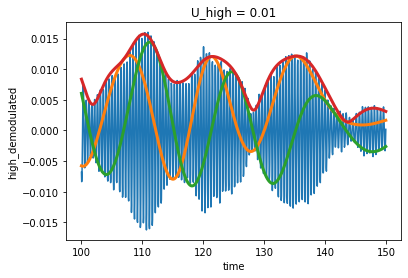

In [21]:
## generate slightly different harmonics

# random
da_high = tseries("high", params=dict(sigma=2.*rad, T=100), seed=0)
da_high_bis = tseries("high", params=dict(sigma=2.*(1+1/28)*rad, T=100), seed=5)

# or stationary signal
#ratio = 1.
#_da = da_high
#beating = (np.cos(rad*_da.sigma*_da.time) 
#           + ratio*np.cos(rad*_da.sigma*(1+1/28) *_da.time)
#          )/np.sqrt(1**2+ratio**2)

with xr.set_options(keep_attrs=True):
    #_da_high = da_high
    _da_high = (da_high + da_high_bis)/np.sqrt(2)

ds = xr.merge([_da_high, da_low], combine_attrs="no_conflicts")

# filter and autocorrelate
#sigma, hbandwidth = ds.sigma, 2/ds.T_high
sigma, hbandwidth = ds.sigma, 2/15
ds, h, h_hat, w = sigp.bpass_demodulate(ds, sigma/rad, hbandwidth, T_window)
R = autocorrelations(ds, combine=True)

_ds = ds.isel(U_high=0, time=slice(24*100,24*150))
_ds["high"].plot()
np.real(_ds["high_demodulated"]).plot(lw=3)
np.imag(_ds["high_demodulated"]).plot(lw=3)
np.abs(_ds["high_demodulated"]).plot(lw=3)

(0.0, 100.0)

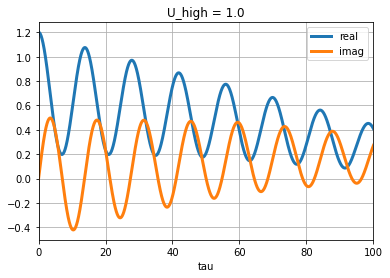

In [22]:
_ds = R.sel(U_high=1)

fig, ax = plt.subplots(1,1)

np.real(_ds["high"]).plot.line(x="tau", label="real", lw=3)
np.imag(_ds["high"]).plot.line(x="tau", label="imag", lw=3)

ax.grid()
ax.legend(loc="upper right")
ax.set_ylabel(None)
ax.set_xlim(0, 100)

---

## things remaining to be done, questions

- show impact of a low frequency contribution on the estimate of the lag, better synthesis
- illustrate stationary case? (issue with mean in autocorrelation computation)
- illustrate effect of neighbooring stationary frequencies
- sensitivity to filter kernel length?
- show statistical accuracy of the lag/variance estimate as a function of time window ?
- can the fast decorrelation of the band-passed low frequency enveloppes be leveraged when the high frequency signal exhibit a larger correlation? Can we quantify the decorrelation timescale of the band-passed low frequency enveloppe?